<a href="https://colab.research.google.com/github/Chinmay-1907/Alzheimer-s_Severity_Prediction_Model-/blob/main/Alzhemers_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import os
import tensorflow as tf
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Download dataset using API
dataset_root = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

# 2. Set paths to both subfolders
original_path = os.path.join(dataset_root, "OriginalDataset")
augmented_path = os.path.join(dataset_root, "AugmentedAlzheimerDataset")

# 3. Create a list of file paths and labels from both directories
def collect_image_paths_and_labels(base_path):
    filepaths = []
    labels = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    filepaths.append(os.path.join(class_path, fname))
                    labels.append(class_name)
    return filepaths, labels

# 4. Combine both Original and Augmented datasets
orig_paths, orig_labels = collect_image_paths_and_labels(original_path)
aug_paths, aug_labels = collect_image_paths_and_labels(augmented_path)

all_paths = orig_paths + aug_paths
all_labels = orig_labels + aug_labels

# 5. Create DataFrame (like ideal code)
df = pd.DataFrame({
    "filepaths": all_paths,
    "labels": all_labels
})

print("Total Images:", len(df))
print("Classes:")
print(df["labels"].value_counts())

100%|██████████| 380M/380M [00:03<00:00, 127MB/s]

Extracting files...


Total Images: 40384
Class Distribution:
labels
NonDemented         12800
VeryMildDemented    11200
MildDemented         9856
ModerateDemented     6528
Name: count, dtype: int64


In [5]:
df.shape

(40384, 2)

In [3]:
from sklearn.model_selection import train_test_split

# Train + Val - Test (30% of all data)
trainval_df, test_df = train_test_split(df, test_size=0.3, random_state= 10, stratify=df["labels"])

# Now split trainval into training and validation (20% of trainval → validation)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state= 10, stratify=trainval_df["labels"])

What is flow_from_dataframe()?

Takes a pandas DataFrame where: What we have now
- One column has full image ***File Paths***
- Another has the labels

Its then able to
- Loads the image from disk (Memory Efficient)
- Applies resizing, augmentation, preprocessing, etc.
- Batches them automatically for training
- Assigns labels based on the column you specify


🗂 DataFrame (paths + labels) → 🍽️ Batches of preprocessed images ready for the model


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Use built-in preprocessing from MobileNetV2 (scale images to expected range)
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [12]:
target_size = (224, 224)
batch_size = 32

train = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

Found 22614 validated image filenames belonging to 4 classes.


In [13]:

val = image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 5654 validated image filenames belonging to 4 classes.


In [14]:
test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


Found 12116 validated image filenames belonging to 4 classes.


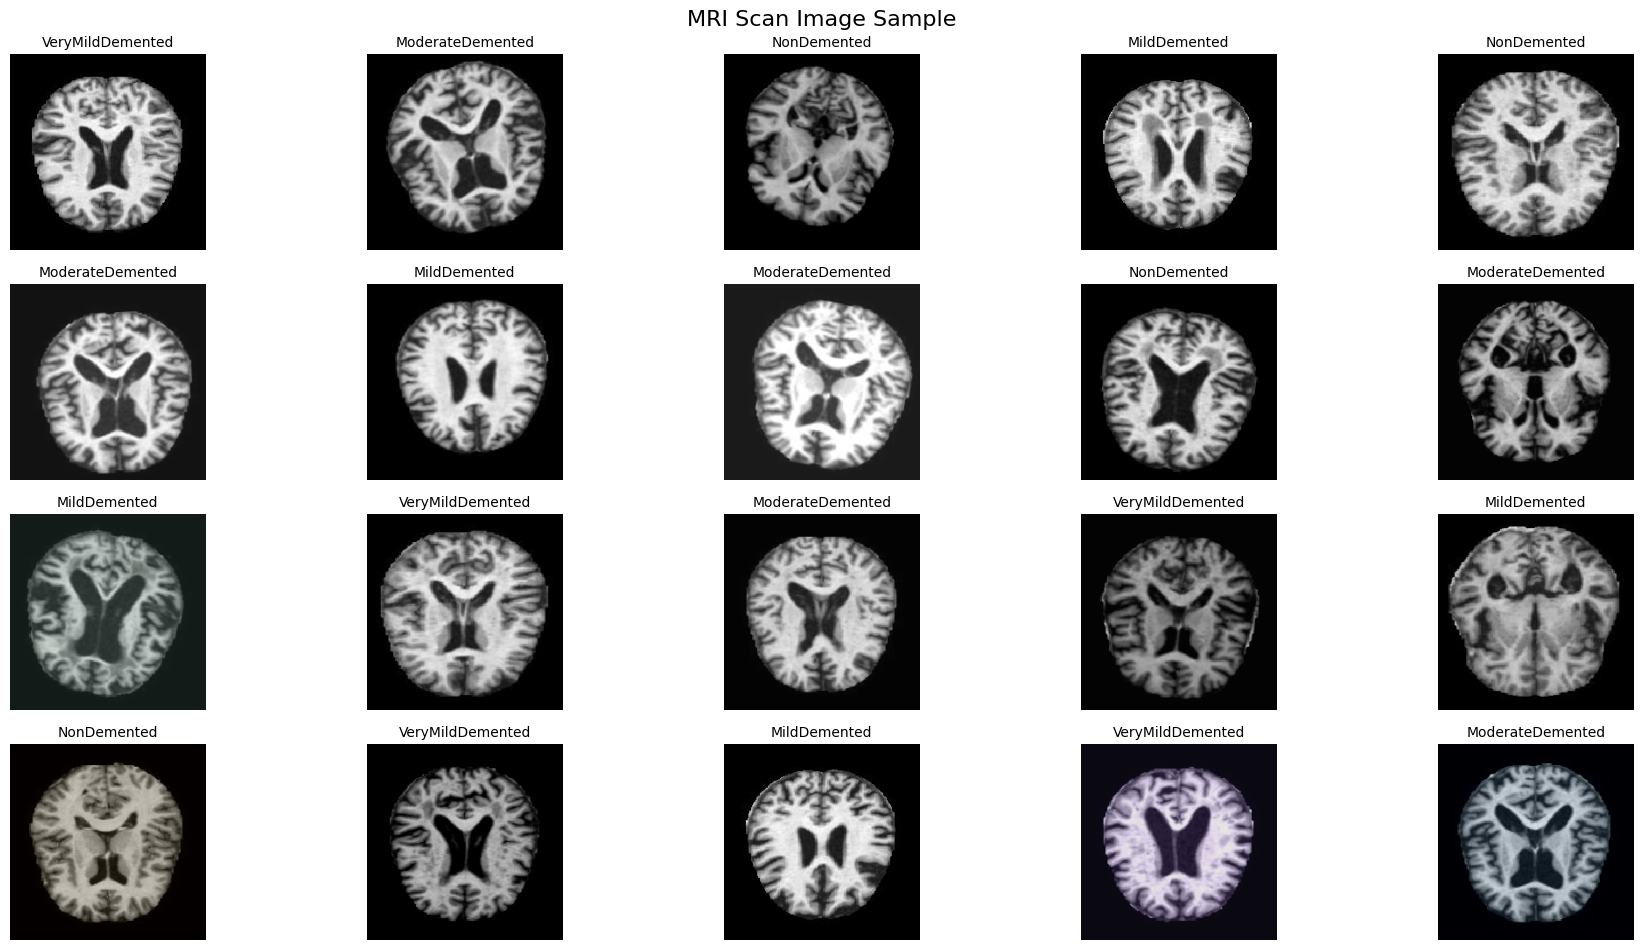

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(generator, title="MRI Scan Image Sample"):
    class_indices = generator.class_indices
    classes = list(class_indices.keys())

    # Fetch one batch of images and labels
    images, labels = next(generator)

    plt.figure(figsize=(18, 12))
    num_images = min(20, len(images))

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # normalization ([-1,1] → [0,1])
        plt.imshow(image)
        label_index = np.argmax(labels[i])
        class_name = classes[label_index]
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 25 images from the training generator
show_sample_images(train)


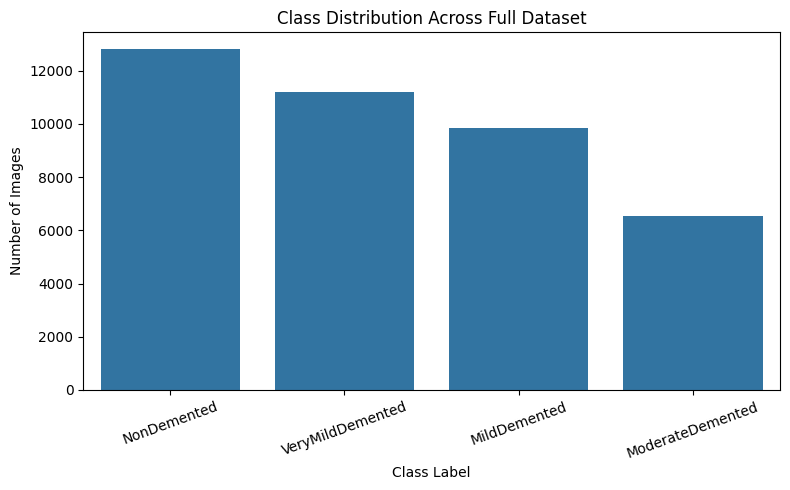

In [17]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="labels", order=df["labels"].value_counts().index)
plt.title("Class Distribution Across Full Dataset")
plt.xticks(rotation=20)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


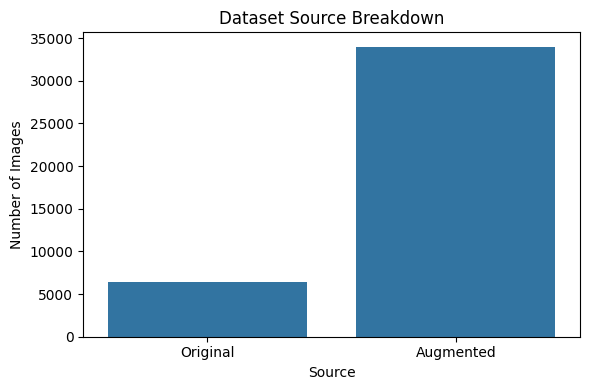

In [18]:
def get_source(filepath):
    if "OriginalDataset" in filepath:
        return "Original"
    elif "AugmentedAlzheimerDataset" in filepath:
        return "Augmented"
    else:
        return "Unknown"

df["source"] = df["filepaths"].apply(get_source)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="source")
plt.title("Dataset Source Breakdown")
plt.xlabel("Source")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


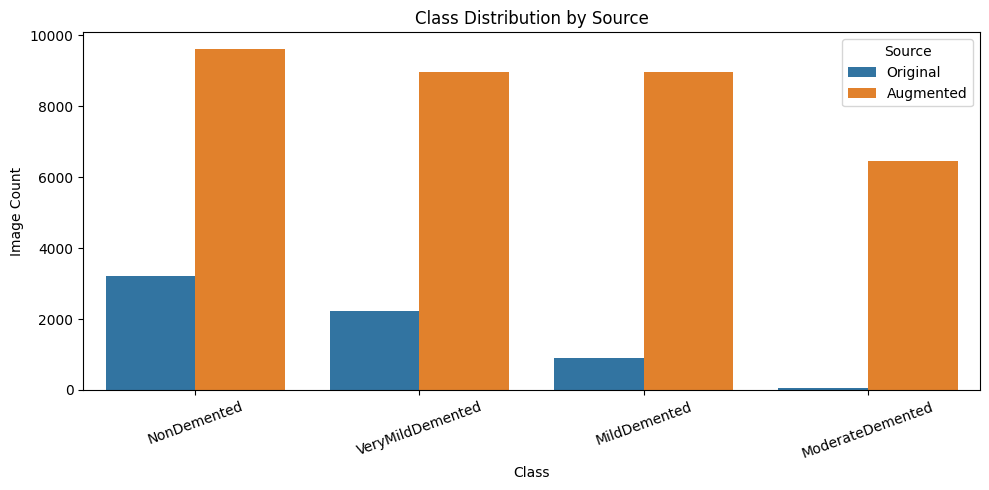

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="labels", hue="source", order=df["labels"].value_counts().index)
plt.title("Class Distribution by Source")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=20)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


## Building the Model

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, (8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),

    # Block 2
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 6
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])


In [ ]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=3,               # Stop if it doesn't improve for 3 epochs
    restore_best_weights=True,  # Go back to the best model (not last epoch)
    verbose=1
)


In [ ]:
history = model.fit(
    train,
    epochs=30,  # Set a max limit
    validation_data=val,
    callbacks=[early_stop],  # 👈 include EarlyStopping
    verbose=1
)
